In [113]:
import matplotlib.pyplot as plt
import numpy as np

import cv2
import dlib
print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


### Step 1. 스티커 구하기 or 만들기

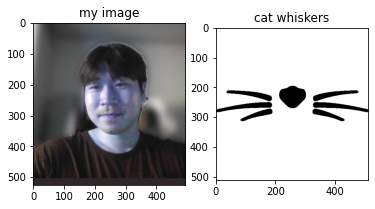

In [114]:
## 이미지 경로 설정
my_image_path = "./images/"

## OpenCV로 이미지 불러오기
myimage_bgr = cv2.imread(my_image_path + "myimage.png")
cat_whiskers = cv2.imread(my_image_path + "cat-whiskers.png")

## 이미지 원본을 따로 보관
my_img_show = myimage_bgr.copy()

## 이미지 출력
plt.subplot(1,2,1)
plt.imshow(myimage_bgr)
plt.title("my image")

plt.subplot(1,2,2)
plt.imshow(cat_whiskers)
plt.title("cat whiskers")
plt.show()

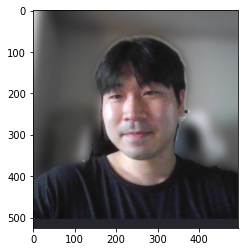

In [115]:
## BGR -> RGB 로 변환
my_img_show = cv2.cvtColor(my_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(my_img_show)
plt.show()

### Step 2. 얼굴 검출 & 랜드마크 검출하기

In [116]:
## detector 선언
detector_hog = dlib.get_frontal_face_detector() 

## upsampling을 통해 크기를 키우기
dlib_rects = detector_hog(my_img_show, 1)

## 얼굴 영역 확인
print(dlib_rects)

rectangles[[(159, 160) (345, 345)]]


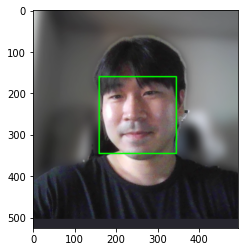

In [117]:
### 얼굴 검출
for dlib_rect in dlib_rects:
    ## 얼굴 좌표
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    ## 시작점과 종료점 좌표의 사각형 설정
    cv2.rectangle(my_img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
plt.imshow(my_img_show)
plt.show()

얼굴 바운딩 박스: 
* left   : 159
* top    : 160
* right  : 345
* bottom : 345

In [118]:
### 랜드마크 검출
## 모델 경로 설정
model_path = './models/shape_predictor_68_face_landmarks.dat'

## landmark 모델 선언
landmark_predictor = dlib.shape_predictor(model_path)

In [119]:
## landmark 위치 저장 list 생성
list_landmarks = []

## 얼굴 바운딩 박스 내의 face landmark 찾기
## 얼굴이 하나이므로 하나의 얼굴에 대한 face landmark 찾기
for dlib_rect in dlib_rects:
    ## 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(my_img_show, dlib_rect)
    
    ## 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장    
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    
    ## list_landmarks에 랜드마크 리스트를 저장
    list_landmarks.append(list_points)
    
## 68개의 좌표(튜플)이 face landmark로 저장되어있음
print(len(list_landmarks[0]))

68


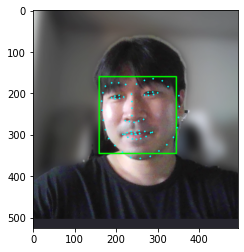

In [120]:
### 랜드마크 검출 시각화
for landmark in list_landmarks: ## 1개의 얼굴
    for point in landmark: ## 68개의 좌표
        ## 크기가 2이고 (0, 255, 255) 색으로 내부가 채워진(-1) 원 그림
        cv2.circle(my_img_show, point, 2, (0, 255, 255), -1)

plt.imshow(my_img_show)
plt.show()

### Step 3. 스티커 적용 위치 확인하기

In [121]:
## 33번 코 위치를 중심으로 설정 ->  -> 30번과 33번 사이
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    ## 이미지에서 코 위치의 x값 -> 소숫점 버리기
    x = int((landmark[30][0] + landmark[33][0]) / 2)
    ## 이미지에서 코 위치의 y값 -> 소숫점 버리기
    y = int((landmark[30][1] + landmark[33][1]) / 2)
    ## 얼굴 박스 검출
    w = h = dlib_rect.width()
    
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(238, 254)
(x,y) : (240,262)
(w,h) : (187,187)


In [122]:
## 시작점 top-left
## 243 - 187//2
refined_x = x - w // 2 
## 270 + 187//2 
refined_y = y - h //2

In [123]:
## 고양이 수염 스티커 사이즈를 얼굴 박스 형태에 재설정
cat_whiskers = cv2.resize(cat_whiskers, (w,h))
print (cat_whiskers.shape)

(187, 187, 3)


### Step 4. 스티커 적용하기

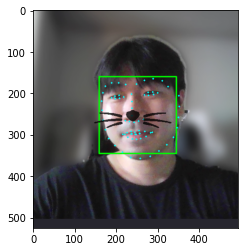

In [124]:
## 원래 영역의 픽셀값 저장 
sticker_area = my_img_show[refined_y:refined_y+cat_whiskers.shape[0], refined_x:refined_x+cat_whiskers.shape[1]]

## 0(검은색)을 제외하고 원래 영역의 픽셀값을 가져온다. 
# sticker_matrix = np.where(cat_whiskers==0, cat_whiskers, sticker_area).astype(np.uint8)
# my_img_show[refined_y:refined_y+cat_whiskers.shape[0], refined_x:refined_x+cat_whiskers.shape[1]] = sticker_matrix

## 스티커 투명도 조절
sticker_matrix = np.where(cat_whiskers==0, cat_whiskers, sticker_area).astype(np.uint8)
sticker_matrix_weighted = cv2.addWeighted(sticker_area, 0.2, sticker_matrix, 0.8, 0)
my_img_show[refined_y:refined_y+cat_whiskers.shape[0], refined_x:refined_x+cat_whiskers.shape[1]] = sticker_matrix_weighted

## 스티커 적용
plt.imshow(my_img_show) 
plt.show()

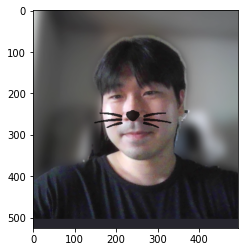

In [125]:
### 원본 사진에 스티커 적용
## 원래 영역의 픽셀값 저장 
sticker_area = myimage_bgr[refined_y:refined_y+cat_whiskers.shape[0], refined_x:refined_x+cat_whiskers.shape[1]]

## 0(검은색)을 제외하고 원래 영역의 픽셀값을 가져온다. 
# sticker_matrix = np.where(cat_whiskers==0, cat_whiskers, sticker_area).astype(np.uint8)
# myimage_bgr[refined_y:refined_y+cat_whiskers.shape[0], refined_x:refined_x+cat_whiskers.shape[1]] = sticker_matrix

## 스티커 투명도 조절
sticker_matrix = np.where(cat_whiskers==0, cat_whiskers, sticker_area).astype(np.uint8)
sticker_matrix_weighted = cv2.addWeighted(sticker_area, 0.2, sticker_matrix, 0.8, 0)
myimage_bgr[refined_y:refined_y+cat_whiskers.shape[0], refined_x:refined_x+cat_whiskers.shape[1]] = sticker_matrix_weighted

## 스티커 적용
plt.imshow(cv2.cvtColor(myimage_bgr, cv2.COLOR_BGR2RGB)) 
plt.show()

### Step 5. 문제점 찾아보기

In [ ]:
### 1. 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

